# **Speech Emotion Recognition (Audio + CNN + RNN)** #

Key Concepts:
Audio data preprocessing: Sampling rate, MFCC (Mel Frequency Cepstral Coefficients), spectrograms

CNNs + RNNs combo: CNNs for spatial feature extraction (spectrogram images), RNNs (typically LSTM/GRU) for temporal sequence learning

Emotion classification: Usually multiclass classification (e.g., angry, happy, sad, neutral, etc.)

Emotion Code	Emotion

01	            Neutral

02	            Calm

03	            Happy

04	            Sad

05	            Angry

06	            Fearful

07	            Disgust

08	            Surprised

In [1]:
pip install librosa numpy pandas scikit-learn matplotlib tensorflow soundfile ipywidgets resampy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Emotion labels mapping
emotions = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# Extract features (MFCC)
def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs.T, axis=0)
    return mfccs_scaled

# Path to audio files
dataset_path = "Dataset"
features = []

# Iterate through all wav files
for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            try:
                emotion_code = file.split("-")[2]
                emotion = emotions[emotion_code]
                data = extract_features(file_path)
                features.append([data, emotion])
            except Exception as e:
                print(f"Error with {file_path}: {e}")

# Convert to DataFrame
df = pd.DataFrame(features, columns=['feature', 'emotion'])
print("Feature shape:", df.shape)
df.head()


Feature shape: (1440, 2)


,feature,emotion
0,"[-700.04803, 58.141853, -2.5586066, 15.606679,...",neutral
1,"[-695.1851, 58.72073, -4.8757935, 19.315145, 5...",neutral
2,"[-693.6901, 61.060158, -2.849076, 16.58725, 2....",neutral
3,"[-687.24304, 58.965412, -0.27530554, 16.264652...",neutral
4,"[-729.57996, 65.91619, -0.40742573, 18.537952,...",calm


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Convert feature column to numpy array
X = np.array(df['feature'].tolist())
X = X.reshape(X.shape[0], X.shape[1], 1)  # Add channel dimension

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df['emotion'])
y = to_categorical(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')


Train shape: (1152, 40, 1), Test shape: (288, 40, 1)


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, LSTM, Dense, Flatten, BatchNormalization

model = Sequential()

# Convolutional Block
model.add(Conv1D(64, kernel_size=5, strides=1, activation='relu', input_shape=(X.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Second Conv Block
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# LSTM Block
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(y.shape[1], activation='softmax'))

# Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 36, 64)            384       
                                                                 
 batch_normalization (BatchN  (None, 36, 64)           256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 18, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 128)           24704     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 128)          5

In [5]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))



Epoch 1/50
36/36 [==============================] - 3s 19ms/step - loss: 2.0713 - accuracy: 0.1623 - val_loss: 2.0263 - val_accuracy: 0.2049
Epoch 2/50
36/36 [==============================] - 0s 7ms/step - loss: 1.9908 - accuracy: 0.2248 - val_loss: 1.9568 - val_accuracy: 0.2431
Epoch 3/50
36/36 [==============================] - 0s 7ms/step - loss: 1.9054 - accuracy: 0.2743 - val_loss: 1.8734 - val_accuracy: 0.2812
Epoch 4/50
36/36 [==============================] - 0s 7ms/step - loss: 1.8540 - accuracy: 0.2847 - val_loss: 1.8144 - val_accuracy: 0.3160
Epoch 5/50
36/36 [==============================] - 0s 7ms/step - loss: 1.8088 - accuracy: 0.3108 - val_loss: 1.7744 - val_accuracy: 0.3333
Epoch 6/50
36/36 [==============================] - 0s 7ms/step - loss: 1.7710 - accuracy: 0.3220 - val_loss: 1.7169 - val_accuracy: 0.3646
Epoch 7/50
36/36 [==============================] - 0s 7ms/step - loss: 1.7502 - accuracy: 0.3411 - val_loss: 1.6947 - val_accuracy: 0.3715
Epoch 8/50
36/36 [=

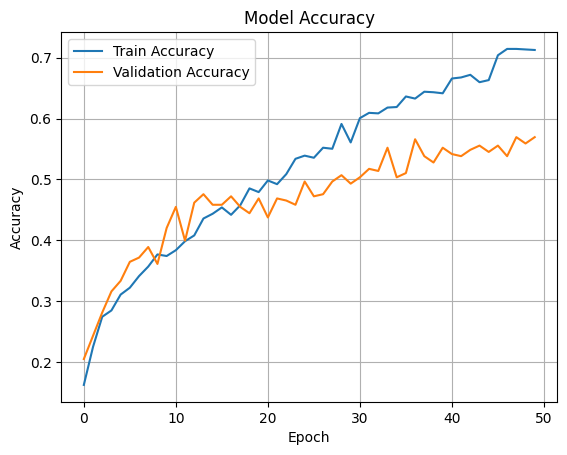

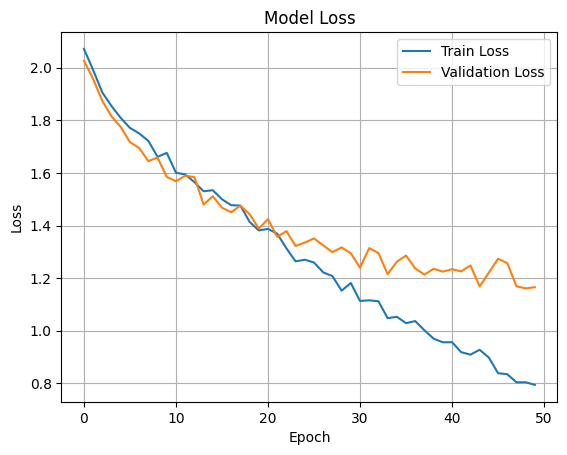

In [6]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



9/9 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       angry       0.67      0.62      0.64        39
        calm       0.53      0.87      0.66        38
     disgust       0.55      0.69      0.61        39
     fearful       0.70      0.49      0.58        39
       happy       0.62      0.39      0.48        38
     neutral       0.29      0.11      0.15        19
         sad       0.49      0.45      0.47        38
   surprised       0.56      0.71      0.63        38

    accuracy                           0.57       288
   macro avg       0.55      0.54      0.53       288
weighted avg       0.57      0.57      0.55       288



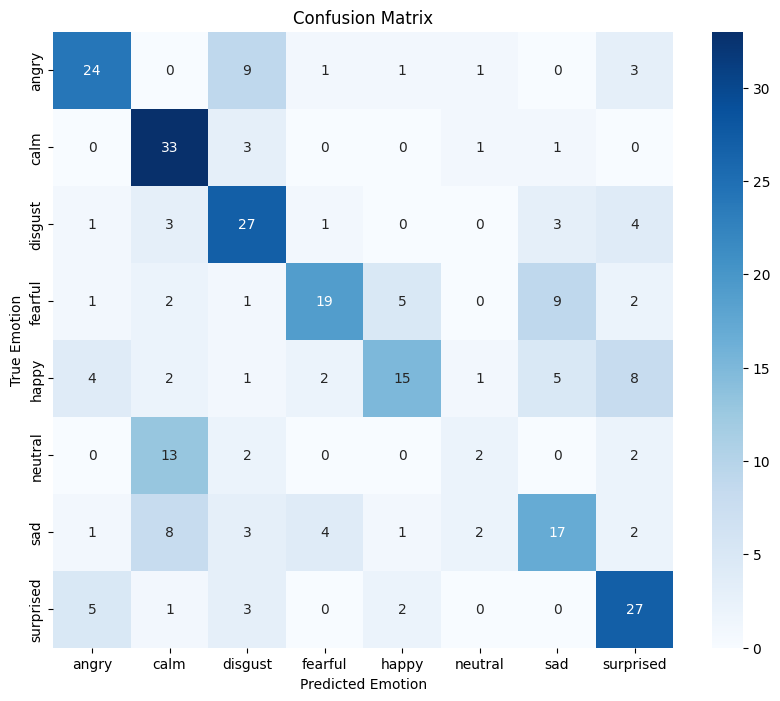

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Classification Report
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Emotion')
plt.xlabel('Predicted Emotion')
plt.show()


In [8]:
import librosa
import numpy as np

def extract_features(file_path):
    data, sample_rate = librosa.load(file_path, duration=2.5, offset=0.6)
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
    padded = np.zeros((40, 174))
    padded[:, :mfcc.shape[1]] = mfcc
    return padded

# Load custom audio
custom_mfcc = extract_features("your_audio.wav")
custom_mfcc = custom_mfcc.reshape(1, 40, 174, 1)

# Predict
prediction = model.predict(custom_mfcc)
predicted_label = emotions[np.argmax(prediction)]
print("Predicted Emotion:", predicted_label)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12940\1655978579.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sample_rate = librosa.load(file_path, duration=2.5, offset=0.6)
C:\Users\Lenovo\anaconda3\envs\ml-gpu\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'your_audio.wav'